# TF-Keras Functional API

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

tf_keras = tf.contrib.keras

In [3]:
# load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf_keras.datasets.mnist.load_data(
    "mnist.npz")

11223040/11490434 [============================>.] - ETA: 0s

In [14]:
x_train.shape

(60000, 28, 28)

In [15]:
y_train.shape


(60000,)

In [17]:
x_test.shape

(10000, 28, 28)

In [18]:
y_test.shape

(10000,)

In [29]:
def plot_10_by_10_images(images):

    # figure size
    fig = plt.figure(figsize=(8, 8))
    
    # crop image
    images = [image[3:25, 3:25] for image in images]
    
    # plot image grid
    for x in range(10):
        for y in range(10):
            ax = fig.add_subplot(10, 10, 10*y+x+1)
            ax.matshow(images[10*y+x], cmap = matplotlib.cm.binary)
            plt.xticks(np.array([])) # remove x ticks
            plt.yticks(np.array([])) # remove y ticks
    plt.show()

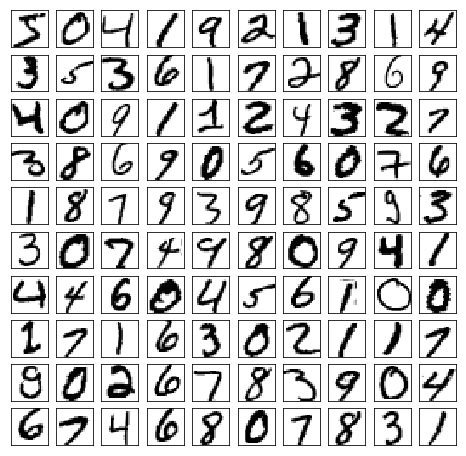

In [30]:
plot_10_by_10_images(x_train[:100])

# Preprocess Images

Before we can build and train a model, the dataset first needs to be reshaped and preprocessed.

## Preprocessing Steps

- reshaped train and test input data into **4D tensors** (batch, width, height, channel)
- reshape train and test target data into **one-hot** vector encoding
- normalize pixel values **from 0-255 to 0-1** for better training

<img src="images/onehotencoding.png" width="800">

In [41]:
def preprocess_images(x_train, y_train, x_test, y_test, num_classes):
    # expand to 4d tensor
    X_train = np.expand_dims(x_train, axis=3) 
    X_test = np.expand_dims(x_test, axis=3)

    # normalize images
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255

    # binarize target matrix (one-hot vector encoding)
    Y_train = tf_keras.utils.to_categorical(y_train, num_classes)
    Y_test = tf_keras.utils.to_categorical(y_test, num_classes)

    print('X_train shape:', X_train.shape)
    print('Y_train shape:', Y_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
    
    return (X_train, Y_train), (X_test, Y_test)

# Run Preprocess Step

In [42]:
# number of classes
num_class = 10

# preprocess images
(X_train, Y_train), (X_test, Y_test) = preprocess_images(x_train, y_train, x_test, y_test, num_class)

X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
60000 train samples
10000 test samples


# Model Hyper-parameters

_hyper-parameters_ are not trainable and are set by the user. The optimial hyper-parameters are usually found through experimental search, often called _hyper-parameter tuning_.

### Good initial hyper-parameters to get started with mnist model.

In [45]:
params = {
    "num_classes": 10, # number of classes
    "input_shape": (28,28,1), # input image size
    "conv_filters": 16, # number of convolutional feature maps
    "conv_kernel": (3,3), # convolutional feature map size
    "pool_kernel": (2,2), # pooling window size
    "dense_size": 128, # size of fully connect layer
    "dropout": 0.4, # ratio of neurons to drop during trainin
    "learning_rate": 0.01 # learning rate
}

# Simple CNN Architecture


In [47]:

def simpleCNN(params):  

    # TensorFlow default graph
    tf.reset_default_graph()

    # input image tensor
    inputs = tf_keras.layers.Input(shape = params["input_shape"])

    # convolutional layer
    net = tf_keras.layers.Conv2D(params["conv_filters"], params["conv_kernel"],
                                 padding= 'same', activation=tf.nn.relu)(inputs)

    # maxpooling layer
    net = tf_keras.layers.MaxPool2D(params["pool_kernel"])(net)

    # flatten/reshape layer
    net = tf_keras.layers.Flatten()(net)

    # fully connected layer
    # most of the weights come from the fc layer.
    net = tf_keras.layers.Dense(params["dense_size"], activation=tf.nn.relu)(net)
    
    # dropout layer
    net = tf_keras.layers.Dropout(params["dropout"])(net)

    # fully connected layer
    outputs = tf_keras.layers.Dense(params["num_classes"], activation=tf.nn.softmax)(net)

    # model
    model = tf_keras.models.Model(inputs=inputs, outputs=outputs)

    # SGD/optimizer
    optimizer = tf_keras.optimizers.SGD(lr=params["learning_rate"])

    # compile the model with loss, optimizer and evaluation metrics
    model.compile(loss = tf_keras.losses.categorical_crossentropy,
                  optimizer = optimizer,
                  metrics = [tf_keras.metrics.categorical_accuracy])

    print(model.summary())
    
    return model

## Model Compilation

Before training a model, need to configure the learning process by compiling. It receives three arguments:

- An optimizer
    - This could be an existing optimizer provided by tensorflow (such as rmsprop or adagrad), or a custom Optimizer class
- A loss function
    - This is the objective that the model will try to minimize. It can be an existing tensorflow loss function (such as categorical_crossentropy or mse), or it can be a custom objective function.
- A list of metrics
    - For any classification problem you can set the evaluation metric that the model will test its performance on. A metric could be an existing tensorflow metric or a custom metric function.



In [48]:
model = simpleCNN(params)# SGD/optimizer
optimizer = tf_keras.optimizers.SGD(lr=0.001)

model.compile(loss = tf_keras.losses.categorical_crossentropy,
              optimizer = optimizer,
              metrics = [tf_keras.metrics.categorical_accuracy])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

# Train Neural Network


In [49]:
model.fit(x=X_train, y=Y_train, batch_size=64,
          verbose=1, epochs=6, validation_data=(X_test,Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 19s - loss: 0.8182 - categorical_accuracy: 0.7596 - val_loss: 0.3061 - val_categorical_accuracy: 0.9136
Epoch 2/6
60000/60000 [==============================] - 3s - loss: 0.3503 - categorical_accuracy: 0.8975 - val_loss: 0.2298 - val_categorical_accuracy: 0.9322
Epoch 3/6
60000/60000 [==============================] - 3s - loss: 0.2868 - categorical_accuracy: 0.9157 - val_loss: 0.1872 - val_categorical_accuracy: 0.9441
Epoch 4/6
60000/60000 [==============================] - 3s - loss: 0.2513 - categorical_accuracy: 0.9256 - val_loss: 0.1670 - val_categorical_accuracy: 0.9493
Epoch 5/6
60000/60000 [==============================] - 6s - loss: 0.2280 - categorical_accuracy: 0.9344 - val_loss: 0.1566 - val_categorical_accuracy: 0.9535
Epoch 6/6
60000/60000 [==============================] - 2s - loss: 0.2094 - categorical_accuracy: 0.9390 - val_loss: 0.1371 - val_categorical_accura

# Evaluate Model Performance


In [61]:
score = model.evaluate(X_test, Y_test, verbose=1)
print
print('Test score:', score[0])
print('Test accuracy:', score[1])

 8960/10000 [=========================>....] - ETA: 0sTest score: 0.137102389495
Test accuracy: 0.9593


# Testing

In [51]:
# make predictions from trained model
class_probabilities = model.predict(X_test[:10])

predictions = np.argmax(class_probabilities, axis=1)
print("Prediction: {}".format(predictions))

Prediction: [7 2 1 0 4 1 4 9 6 9]


# Plot Predictions

In [58]:
def plot_images_together(images, predictions):
    pred_str = "   ".join(map(str,predictions))
    
    fig = plt.figure(figsize=(30, 6))
    images = [image[:, 3:25] for image in images]
    image = np.concatenate(images, axis=1)
    
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(image, cmap = matplotlib.cm.binary)
    
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    
    plt.text(0.5, -0.5,pred_str, fontsize=100, horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes,
             bbox=dict(facecolor='green', alpha=0.4))
    plt.show()

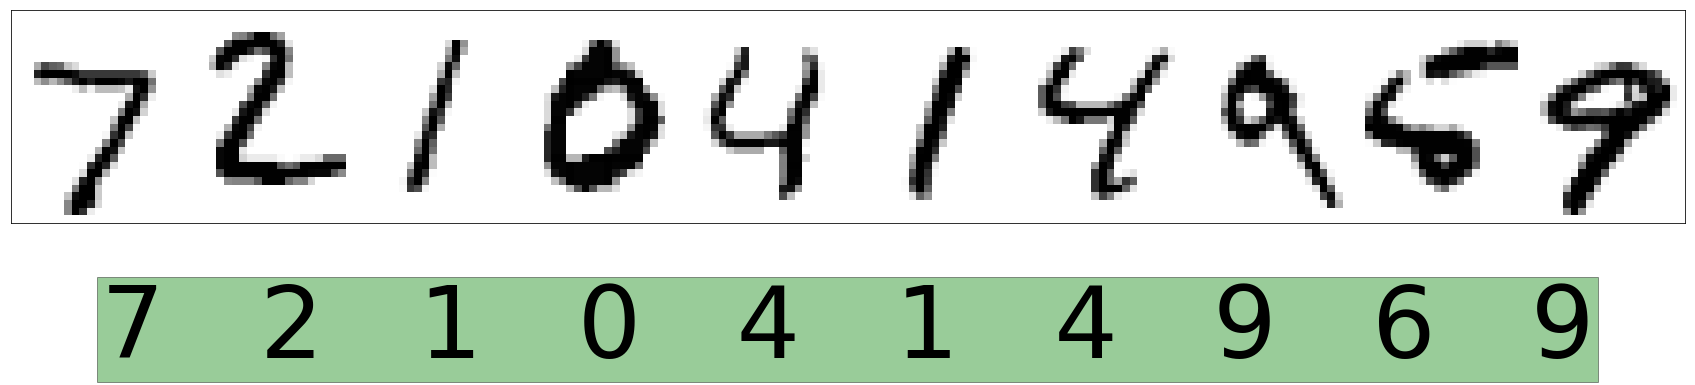

In [59]:
plot_images_together(x_test[:10], predictions)